In [2]:
from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr

import numpy as np
import pandas as pd
import image_utils as iu
import tensorflow as tf
import os
from PIL import Image, ImageEnhance
from PIL import ImageFilter
from keras.models import load_model
from shutil import copy2
import matplotlib.pyplot as plt
import geotiff_utils as gu
from IPython.display import display, HTML
from ipycanvas import Canvas
from ipywidgets import Image as ipyImage
from pyproj import Proj, transform
import uuid
import shutil

In [4]:
data_path = 'data'
segmentation_path = os.path.join(data_path, 'segmentation')
original_path = os.path.join(segmentation_path, 'original')
real_data_path = os.path.join(original_path, 'real')
mask_data_path = os.path.join(original_path, 'mask')
# divided images
divided_data_path = os.path.join(segmentation_path, 'divided')
real_divided_data_path = os.path.join(divided_data_path, 'real')
mask_divided_data_path = os.path.join(divided_data_path, 'mask')
#
final_data_path = os.path.join(segmentation_path, 'final')
real_final_data_path = os.path.join(final_data_path, 'real')
mask_final_data_path = os.path.join(final_data_path, 'mask')
#Html Path
html_path = 'html'
# Saved models
saved_model_path = os.path.join(segmentation_path, 'saved-models')
# Predictions path.
prediction_path = os.path.join(segmentation_path, 'predictions')


In [3]:
def plot_histogram(labels, values):
    fig = plt.figure(figsize=(20, 8))
    ax = fig.add_axes([0, 0, 1, 1])
    bars = ax.bar(labels, values)
    plt.bar_label(bars)
    plt.xticks(rotation=90)
    plt.ylabel('Area km²')
    plt.xlabel('Class')
    plt.show()


In [4]:
#The pixel values in the geo tiff image is used to represent a land map class.
class_encoding = {2: 'Degraded Gallery Forest',
                      3: 'Wetland',
                      4: 'Landfill',
                      6: 'Plantation',
                      7: 'Mangrove',
                      8: 'Agric',
                      9: 'Waterbody',
                      10: 'Sandy Area',
                      11: 'Rocky Land',
                      12: 'Bare Soil',
                      13: 'Settlement',
                      14: 'Irrigated Agric',
                      15: 'Gallery',
                      16: 'Shrub and Tee Savanna',
                      17: 'Wooded Savanna',
                      18: 'Forest',
                      19: 'Salt Pan',
                      21: 'Degraded',
                      22: 'Bowe',
                      24: 'Agric in Shallow and Recession',
                      25: 'Woodland',
                      31: 'Dam',
                      32: 'Herbaecous Savanna',
                      78: 'Shrub Land',
                      255: 'No Data'}

In [5]:
# The color code or legend for each class is defined for visualization
color_encoding = {2: [255, 0, 0],  # Degraded Gallery Forest
                  3: [60, 154, 206],  # Wetland
                  4: [50, 50, 50],  # Landfill
                  6: [0, 255, 0],  # Plantation
                  7: [98, 124, 61],  # Mangrove
                  8: [217, 212, 12],  # Agric
                  9: [0, 1, 128],  # Waterbody
                  10: [255, 223, 167],  # Sandy Area
                  11: [180, 96, 0],  # Rocky Land
                  12: [142, 125, 115],  # Bare Soil
                  13: [251, 72, 196],  # Settlement
                  14: [179, 227, 214],  # Irrigated Agric
                  15: [255, 128, 64],  # Gallery
                  16: [41, 49, 28],  # Shrub and Tee Savanna
                  17: [231, 177, 106],  # Wooded Savanna
                  18: [65, 100, 34],  # Forest
                  19: [50, 50, 50],  # Salt Pan
                  21: [119, 85, 60],  # Degraded
                  22: [128, 64, 255],  # Bowe
                  24: [90, 64, 128],  # Agriculture in Shallow and Recession
                  25: [255, 64, 64],  # Woodland
                  31: [0, 255, 255],  # Dam
                  32: [128, 0, 64],  # Herbaecous Savanna
                  78: [255, 255, 255],  # Shrub Land
                  255: [0, 0, 0]}  # No data


In [ ]:
{2: 0,
 3: 1,
 6: 2,
 7: 3,
 8: 4,
 9: 5,
 10: 6,
 11: 7,
 12: 8,
 13: 9,
 14: 10,
 15: 11,
 16: 12,
 17: 13,
 18: 14,
 19: 15,
 21: 16,
 22: 17,
 24: 18,
 25: 19,
 31: 20,
 32: 21,
 78: 22,
 255: 23}


In [6]:
# The color code or legend for each class is defined for visualization
new_color_encoding = {0: [255, 0, 0],  # Degraded Gallery Forest
                  1: [60, 154, 206],  # Wetland
                  2: [0, 255, 0],  # Plantation
                  3: [98, 124, 61],  # Mangrove
                  4: [217, 212, 12],  # Agric
                  5: [0, 1, 128],  # Waterbody
                  6: [255, 223, 167],  # Sandy Area
                  7: [180, 96, 0],  # Rocky Land
                  8: [142, 125, 115],  # Bare Soil
                  9: [251, 72, 196],  # Settlement
                  10: [179, 227, 214],  # Irrigated Agric
                  11: [255, 128, 64],  # Gallery
                  12: [41, 49, 28],  # Shrub and Tee Savanna
                  13: [231, 177, 106],  # Wooded Savanna
                  14: [65, 100, 34],  # Forest
                  15: [50, 50, 50],  # Salt Pan
                  16: [119, 85, 60],  # Degraded
                  17: [128, 64, 255],  # Bowe
                  18: [90, 64, 128],  # Agriculture in Shallow and Recession
                  19: [255, 64, 64],  # Woodland
                  20: [0, 255, 255],  # Dam
                  21: [128, 0, 64],  # Herbaecous Savanna
                  22: [255, 255, 255],  # Shrub Land
                  23: [0, 0, 0]}  # No data

In [6]:
#open the land use land cover map.
geoTiff = gdal.Open(
    os.path.join(data_path, 'Final_RLCM_Ghana_2017.tif'), gdal.GA_ReadOnly)
geoTiff.RasterCount, geoTiff.RasterXSize, geoTiff.RasterYSize, geoTiff.GetMetadata()
xmin_i, xres_i, xskew_i, ymin_i, yskew_r, yres_i = geoTiff.GetGeoTransform()
print('Metadata')
print('No of bands:', geoTiff.RasterCount)
print('Image Resolution:', geoTiff.RasterXSize, 'x',  geoTiff.RasterYSize)
# print('Projection:', geoTiff.GetProjection())
print('Latitude:', xmin_i)
print('Longitude:', ymin_i)
print('Rotation:', xskew_i)
print('Pixel Resolution:', abs(xres_i), 'meters', 'x', abs(yres_i), 'meters')


Metadata
No of bands: 1
Image Resolution: 988 x 1425
Latitude: 471309.17540000007
Longitude: 1236197.3455999997
Rotation: 0.0
Pixel Resolution: 500.0 meters x 500.0 meters


In [ ]:
#
gh_im = gu.get_l_band(geoTiff, 1)
flat_gh_im = gh_im.reshape(-1, 1)
print(flat_gh_im)
#
new_gh_im = []
for x in range(flat_gh_im.shape[0]):
    new_gh_im.append(color_encoding.get(flat_gh_im[x][0]))
#
new_gh_im = np.array(new_gh_im).reshape(gh_im.shape[0], gh_im.shape[1], 3)
enc_im = Image.fromarray(np.array(new_gh_im, dtype=np.uint8))
# enc_im
enc_im.save(os.path.join(html_path, 'land_use_land_cover_map.png'))


In [45]:
def display_legend(np_image, color_encoding):
    flat_gh_im = np_image.reshape(-1, 1)
    #
    new_gh_im = []
    for x in range(flat_gh_im.shape[0]):
        new_gh_im.append(color_encoding.get(flat_gh_im[x][0], [0, 0, 0]))
    #
    new_gh_im = np.array(new_gh_im).reshape(np_image.shape[0], np_image.shape[1], 3)
    enc_im = Image.fromarray(np.array(new_gh_im, dtype=np.uint8))
    return enc_im


In [8]:
display(HTML(os.path.join(html_path, 'index.html')))

In [ ]:
#Read geoTiff into numpy array.
gh_np_im = gu.get_l_band(geoTiff, 1)
gh_np_im = gh_np_im.reshape(-1, 1)
#A map of each pixel and its count is created.
#The value is used to calculate the area of each class on the map.
class_map = dict()
for c in gh_np_im:
    if (c != 255):
       class_map[c[0]] = class_map.get(c[0], 0) + 1
#Map is sorted according to the area each class covers in descending order.
class_map = dict(
    sorted(class_map.items(), key=lambda item: item[1], reverse=True))
classes = []
values = []
for c in class_map:
    classes.append(class_encoding[c])
    values.append(class_map[c] * 0.5 * 0.5)

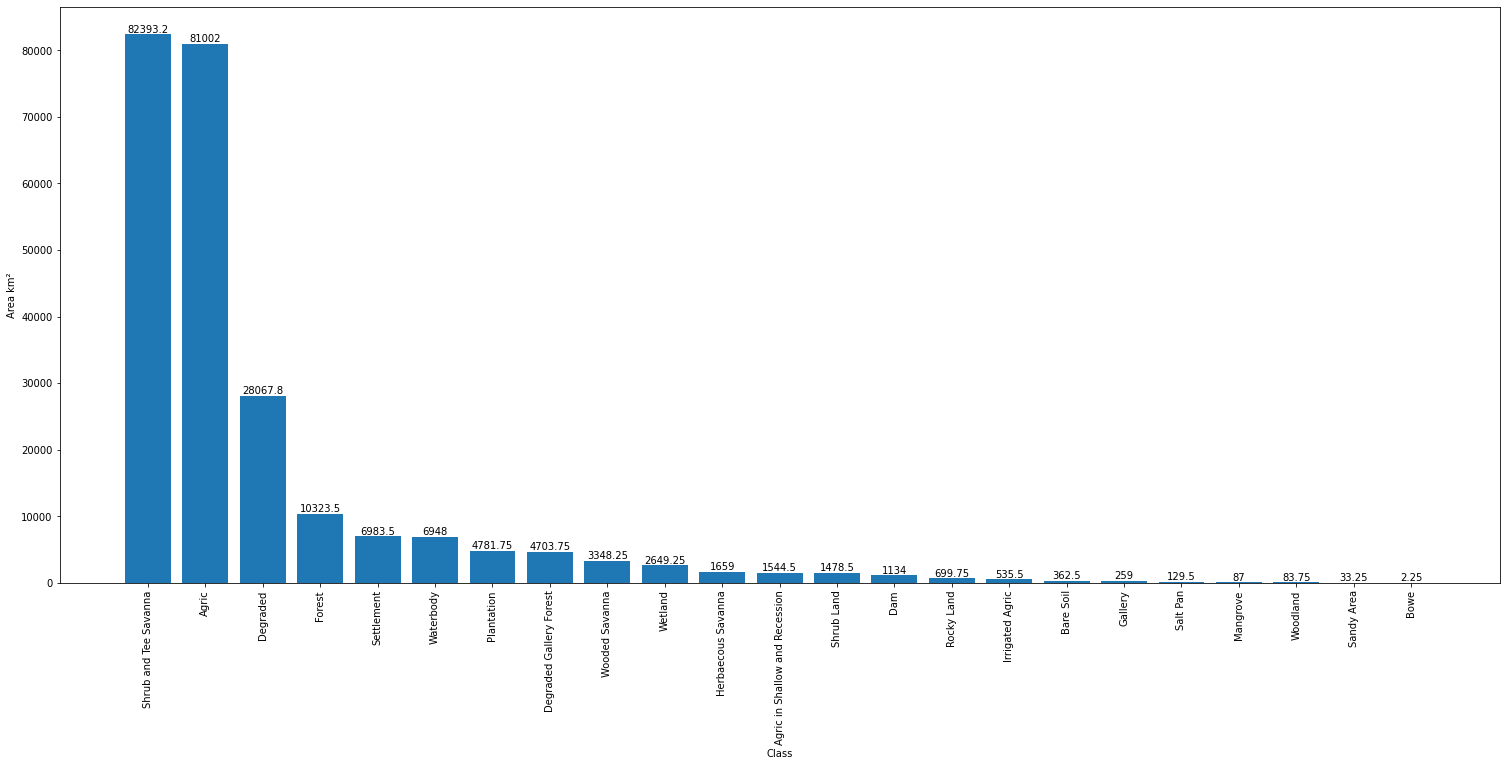

In [165]:
# Histogram of classes and the land cover area is plotted.
plot_histogram(classes, values)

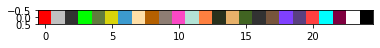

In [144]:
# ec = tuple(e for e in color_encoding.get(78))
color_tuples = []
for key in color_encoding:
    color_tuples.append(tuple(e for e in color_encoding.get(key)))
iu.display_image([color_tuples])


In [7]:
def save_image_as_geotiff(mask, destination_path, dataset, output_dtype=gdal.GDT_UInt16, geoTransform=None):
    mask = mask.resize((dataset.RasterXSize, dataset.RasterYSize))
    array = np.asarray(mask)
    nrows, ncols = array.shape[0], array.shape[1]
    depth = array.shape[2]
    # geotransform = (0, 1024, 0, 0, 0, 512)
    # That's (top left x, w-e pixel resolution, rotation (0 if North is up),
    #         top left y, rotation (0 if North is up), n-s pixel resolution)
    # I don't know why rotation is in twice???
    output_raster = gdal.GetDriverByName('GTiff').Create(
        destination_path, ncols, nrows, depth, output_dtype)  # Open the file
    # print(output_raster)
    if geoTransform == None:
        geoTransform = dataset.GetGeoTransform()
    output_raster.SetGeoTransform(geoTransform)  # Specify its coordinates
    output_raster.SetProjection(dataset.GetProjection())
    output_raster.SetMetadata(output_raster.GetMetadata())
    for x in range(depth):
       output_raster.GetRasterBand(x + 1).WriteArray(
           array[:, :, x])   # Writes my array to the raster
    output_raster.FlushCache()
    

def save_np_array_as_geoTiff(np_array, destination_path, output_dtype=gdal.GDT_UInt16, geoTransform=None, projection=None, metadata=None):
    # np_array = np_array.resize((dataset.RasterXSize, dataset.RasterYSize))
    array = np_array
    height, width = array.shape[0], array.shape[1]
    depth = array.shape[2]
    # geotransform = (0, 1024, 0, 0, 0, 512)
    # That's (top left x, w-e pixel resolution, rotation (0 if North is up),
    #         top left y, rotation (0 if North is up), n-s pixel resolution)
    # I don't know why rotation is in twice???
    output_raster = gdal.GetDriverByName('GTiff').Create(
        destination_path, width, height, depth, output_dtype)  # Open the file
    # print(output_raster)
    if geoTransform:
        output_raster.SetGeoTransform(geoTransform)  # Specify its coordinates
    if projection:
        output_raster.SetProjection(projection)
    if metadata:
        output_raster.SetMetadata(metadata)
    for x in range(depth):
       output_raster.GetRasterBand(x + 1).WriteArray(
           array[:, :, x])   # Writes my array to the raster
    output_raster.FlushCache()
    return output_raster


In [15]:
save_image_as_geotiff(enc_im, 'enc_im.tif', geoTiff)

In [3]:
np_img = gu.get_l_band(geoTiff, 5, 'uint16')

In [4]:
np_n_im = (np_img / np_img.max()) * 255

In [ ]:
#Visualize image
im = Image.fromarray(np.array(np_n_im.reshape(
    np_n_im.shape[0], np_n_im.shape[1]), dtype=np.uint8))
im


In [8]:
gu.save_image_as_geotiff(im, 'data/test.tif', geoTiff)

In [6]:
for x in range(6):
    np_img = gu.get_l_band(geoTiff, x + 1, 'uint16')
    np_n_im = (np_img / np_img.max()) * 255
    im = Image.fromarray(np.array(np_n_im.reshape(
        np_n_im.shape[0], np_n_im.shape[1]), dtype=np.uint8))
    im.save('data/bands/band' + str(x + 1) + '.jpg')


In [8]:
def reproject_coordinate(x, y, init_proj='epsg:32630', final_proj='epsg:3857'):
    inProj = Proj(init=init_proj)
    outProj = Proj(init=final_proj)
    # x1, y1 = 471309.17540000007, 1236197.3455999997
    # x2, y2 = transform(inProj, outProj, x, y)
    x, y = transform(inProj, outProj, x, y)
    return x, y

In [9]:
def reproject_raster(dataset, destination_path, init_proj='epsg:32630', final_proj='epsg:3857'):
    ulx_r, xres_r, xskew_r, uly_r, yskew_r, yres_r = dataset.GetGeoTransform()
    mask = mask.resize((dataset.RasterXSize, dataset.RasterYSize))
    array = np.asarray(mask)
    nrows, ncols = np.shape(array)
    # geotransform = (0, 1024, 0, 0, 0, 512)
    # That's (top left x, w-e pixel resolution, rotation (0 if North is up),
    #         top left y, rotation (0 if North is up), n-s pixel resolution)
    # I don't know why rotation is in twice???
    output_raster = gdal.GetDriverByName('GTiff').Create(
        destination_path, ncols, nrows, 1, gdal.GDT_Byte)  # Open the file
    # print(output_raster)
    output_raster.SetGeoTransform(
        dataset.GetGeoTransform())  # Specify its coordinates
    output_raster.SetProjection(dataset.GetProjection())
    output_raster.SetMetadata(output_raster.GetMetadata())
    srs = osr.SpatialReference()                 # Establish its coordinate encoding
    # This one specifies WGS84 lat long.
    if unit == 'meters':
        srs.ImportFromEPSG(3857)
    elif unit == 'degrees':
        srs.ImportFromEPSG(4326)
   # Anyone know how to specify the
   # IAU2000:49900 Mars encoding?
   # Exports the coordinate system
    output_raster.SetProjection(srs.ExportToWkt())
   # to the file
    output_raster.GetRasterBand(1).WriteArray(
        array)   # Writes my array to the raster
    output_raster.FlushCache()


In [10]:
def rep_raster(output_raster, input_raster):
    ulx_r, xres_r, xskew_r, uly_r, yskew_r, yres_r = input_raster.GetGeoTransform()
    gdal.Warp(output_raster, input_raster, dstSRS='EPSG:32630')


In [11]:
def get_land_map(ds_real, ds_label, dtype='uint16'):
    ulx_r, xres_r, xskew_r, uly_r, yskew_r, yres_r = ds_real.GetGeoTransform()
    ulx_l, xres_l, xskew_l, uly_l, yskew_l, yres_l = ds_label.GetGeoTransform()
    x_res_ratio = xres_l / xres_r
    y_res_ratio = yres_l / yres_r
    x_offset = int(abs(ulx_l - ulx_r) / abs(xres_l))
    y_offset = int(abs(uly_l - uly_r) / abs(yres_l))
    width = ds_real.RasterXSize / x_res_ratio
    height = ds_real.RasterYSize / y_res_ratio
    print(x_offset, y_offset,
          width, height)
    label_bands = []
    for x in range(ds_label.RasterCount):
        band = ds_label.GetRasterBand(x + 1).ReadAsArray(x_offset, y_offset,
                                                     int(width), int(height))
        label_bands.append(band)
    # L = ds_label.GetRasterBand(1).ReadAsArray(x_offset, y_offset,
    #     int(width), int(height))
    rgbOutput = np.zeros(
        (int(height), int(width), ds_label.RasterCount), dtype)
    for x in range(len(label_bands)):
        rgbOutput[..., x] = label_bands[x]
    #Clear so file isn't locked
    source = None
    return rgbOutput


In [12]:
def greater(val1, val2):
    if val1 > val2:
        return val1
    else:
        return val2

def least(val1, val2):
    if val1 < val2:
        return val1
    else:
        return val2
    
def get_corresponding_tile_map(ds_input, ds_output, dtype='uint16'):
    xmin_i, xres_i, xskew_r, ymin_i, yskew_r, yres_i = ds_input.GetGeoTransform()
    xmin_o, xres_o, xskew_o, ymin_o, yskew_o, yres_o = ds_output.GetGeoTransform()
    xmax_i = xmin_i + (abs(xres_i) * ds_input.RasterXSize)
    ymax_i = ymin_i + (abs(yres_i) * ds_input.RasterYSize)
    #output max
    xmax_o = xmin_o + (abs(xres_o) * ds_output.RasterXSize)
    ymax_o = ymin_o + (abs(yres_o) * ds_output.RasterYSize)
    x_offset = (xmin_i - xmin_o) / xres_o
    y_offset = (ymin_i - ymin_o) / yres_o
    if x_offset < 0:
        x_offset = 0
    if y_offset < 0:
        y_offset = 0
    xmin = greater(xmin_i, xmin_o)
    xmax = least(xmax_i, xmax_o)
    ymin = least(ymin_i, ymin_o)
    ymax = least(ymax_i, ymax_o)
    print(xmin, xmax, ymin, ymax)
    width = (xmax - xmin) / abs(xres_o)
    height = (ymax - ymin) / abs(yres_o)
    print(x_offset, y_offset, width, height)
    # band = ds_output.GetRasterBand(1).ReadAsArray(x_offset, y_offset,
    #                                                   int(width), int(height))
    # rgbOutput = np.zeros(
    #     (int(height), int(width), 1), dtype)
    # rgbOutput[..., 0] = band
    label_bands = []
    for x in range(ds_output.RasterCount):
        band = ds_output.GetRasterBand(x + 1).ReadAsArray(x_offset, y_offset,
                                                         int(width), int(height))
        label_bands.append(band)
    # L = ds_label.GetRasterBand(1).ReadAsArray(x_offset, y_offset,
    #     int(width), int(height))
    output = np.zeros(
        (int(height), int(width), ds_output.RasterCount), dtype)
    for x in range(len(label_bands)):
        output[..., x] = label_bands[x]
    #Clear so file isn't locked
    source = None
    return output, (xmin, xres_o, xskew_o, ymin, yskew_o, yres_o)


In [93]:
# geoTiff_real = gdal.Open(
#     '/Users/ernestopoku-kwarteng/Downloads/Sentinel Projected/Sentinel_2_Proj.tif', gdal.GA_ReadOnly)
geoTiff_real = gdal.Open(
    'tiff_sentinel_rep.tif', gdal.GA_ReadOnly)
geoTiff_label = gdal.Open(
    '/Users/ernestopoku-kwarteng/Downloads/points/Final_RLCM_Ghana_2017/Final_RLCM_Ghana_2017.tif', gdal.GA_ReadOnly)


ERROR 4: tiff_sentinel_rep.tif: No such file or directory


In [113]:
for x in range(6):
    np_img = gu.get_l_band(geoTiff_real, x + 1, 'uint16')
    max = np_img.max()
    # print(max)
    np_n_im = (np_img / max) * 255
    im = Image.fromarray(np.array(np_n_im.reshape(
        np_n_im.shape[0], np_n_im.shape[1]), dtype=np.uint8))
    im.save('data/bands/band' + str(x + 1) + '.jpg')


In [44]:
rep_raster('tiff_rep.tif', geoTiff_real)

In [52]:
geoTiff_real.GetGeoTransform()

(447652.8059976852,
 29.9312295943703,
 0.0,
 1253712.3269233608,
 0.0,
 -29.9312295943703)

In [49]:
geoTiff_label.GetGeoTransform()

(471309.17540000007, 500.0, 0.0, 1236197.3455999997, 0.0, -500.0)

In [ ]:
reproject_coordinate(-156543.03390004113, 684875.7733463161,
                     'epsg:3857', 'epsg:32630')

In [16]:
geoTiff_real.GetGeoTransform()

(471309.17540000007, 500.0, 0.0, 1236197.3455999997, 0.0, -500.0)

In [ ]:
np_im = get_land_map(geoTiff_real, geoTiff_label, 'uint8')
# np_n_im = np.array((np_im / np_im.max()) * 255, dtype = "uint8")
Image.fromarray(np_n_im.reshape(np_im.shape[0], np_im.shape[1]))


In [97]:
np_im, geo_transform = get_corresponding_tile_map(geoTiff_label, geoTiff_real, 'uint16')

471309.17540000007 965309.1754000001 1236197.3455999997 1948697.3455999997
790.3574200895629 585.1741328614016 16504.500706944407 23804.568327323665


In [106]:
np_im.max()

13029

In [110]:
save_image_as_geotiff(np_im, 'tiff_sentinel_rep.tif', geoTiff_real, geoTransform=geo_transform)

In [ ]:
Image.fromarray(np_im.reshape(np_im.shape[0], np_im.shape[1]))

In [ ]:
Image.fromarray(np_im[:, :,0])

In [14]:
### Categorical data to be converted to numeric data
colors = ["red", "green", "yellow", "red", "blue", "red"]

### Universal list of colors
total_colors = ["red", "green", "blue", "black", "yellow"]

### map each color to an integer
mapping = {}
for x in range(len(total_colors)):
  mapping[total_colors[x]] = x

one_hot_encode = []

for c in colors:
  arr = list(np.zeros(len(total_colors), dtype=int))
  arr[mapping[c]] = 1
  one_hot_encode.append(arr)

print(one_hot_encode)


[[1, 0, 0, 0, 0], [0, 1, 0, 0, 0], [0, 0, 0, 0, 1], [1, 0, 0, 0, 0], [0, 0, 1, 0, 0], [1, 0, 0, 0, 0]]


In [3]:
from tifffile import tifffile
image = tifffile.imread(
    '/Users/ernestopoku-kwarteng/Downloads/Sentinel Projected/Sentinel_2_Proj.tif')


In [13]:
def get_rgb_bands(tiff, color_depth='uint8'):
    red = tiff.GetRasterBand(1).ReadAsArray()
    green = tiff.GetRasterBand(2).ReadAsArray()
    blue = tiff.GetRasterBand(3).ReadAsArray()
    #rgbOutput = source.ReadAsArray() #Easier method
    rgbOutput = np.zeros((tiff.RasterYSize, tiff.RasterXSize, 3), color_depth)
    # rgbOutput[..., 0] = red
    # rgbOutput[..., 1] = green
    # rgbOutput[..., 2] = blue
    rgbOutput[..., 0] = blue
    rgbOutput[..., 1] = green
    rgbOutput[..., 2] = red
    #Clear so file isn't locked
    source = None
    return rgbOutput


def get_rgb_bands(tiff, color_depth='uint8'):
    red = tiff.GetRasterBand(1).ReadAsArray()
    green = tiff.GetRasterBand(2).ReadAsArray()
    blue = tiff.GetRasterBand(3).ReadAsArray()
    #rgbOutput = source.ReadAsArray() #Easier method
    rgbOutput = np.zeros((tiff.RasterYSize, tiff.RasterXSize, 3), color_depth)
    # rgbOutput[..., 0] = red
    # rgbOutput[..., 1] = green
    # rgbOutput[..., 2] = blue
    rgbOutput[..., 0] = blue
    rgbOutput[..., 1] = green
    rgbOutput[..., 2] = red
    #Clear so file isn't locked
    source = None
    return rgbOutput


In [95]:
def read_geoTiff_bands(geoTiff, dtype='uint16'):
    width = geoTiff.RasterXSize
    height = geoTiff.RasterYSize
    bands = []
    for x in range(geoTiff.RasterCount):
        band = geoTiff.GetRasterBand(x + 1).ReadAsArray()
        bands.append(band)
    output = np.zeros(
        (int(height), int(width), geoTiff.RasterCount), dtype)
    for x in range(len(bands)):
        output[..., x] = bands[x]
    return output

def display_geoTiff(geoTiff, dtype='uint16'):
    np_rgb_image = get_rgb_bands(geoTiff, dtype)
    np_n_im = (np_rgb_image / np_rgb_image.max()) * 255
    im = Image.fromarray(np.array(np_n_im, dtype=np.uint8))
    return im

def display_np_geoTiff(np_geoTiff):
    np_rgb_image = np_geoTiff[:, :, 0:3][:, :, ::-1]
    np_n_im = (np_rgb_image / np_rgb_image.max()) * 255
    im = Image.fromarray(np.array(np_n_im, dtype=np.uint8))
    return im
        
def crop_geoTiff(geoTiff, left, top, right, bottom, dtype ='uint16'):
    width = abs(right - left)
    height = abs(top - bottom)
    bands = []
    for x in range(geoTiff.RasterCount):
        band = geoTiff.GetRasterBand(x + 1).ReadAsArray(left, top,
                                                        int(width), int(height))
        bands.append(band)
    output = np.zeros(
        (int(height), int(width), geoTiff.RasterCount), dtype)
    for x in range(len(bands)):
        output[..., x] = bands[x]
    return output
        
# Splits image into specified rows and columns
def split_geoTiff_image(geoTiff, row_count, col_count):
    parts = []
    width, height = geoTiff.RasterXSize, geoTiff.RasterYSize
    left = 0
    top = 0
    right = width / col_count
    bottom = height / row_count
    # bands = read_geoTiff_bands(geoTiff)
    for r in range(row_count):
        top = int(r * (height / row_count))
        bottom = int(top + (height / row_count))
        for c in range(col_count):
            left = int(c * (width / col_count))
            right = int(left + (width / col_count))
            part = crop_geoTiff(geoTiff, left, top, right, bottom)
            parts.append(part)
    return parts

# Splits image into specified rows and columns
def split_image(image, row_count, col_count):
    parts = []
    width, height = image.size
    left = 0
    top = 0
    right = width / col_count
    bottom = height / row_count
    for r in range(row_count):
        top = int(r * (height / row_count))
        bottom = int(top + (height / row_count))
        for c in range(col_count):
            left = int(c * (width / col_count))
            right = int(left + (width / col_count))
            part = image.crop((left, top, right, bottom))
            parts.append(part)
    return parts


In [31]:
rgb_image = np.array([[[255, 0, 0], [0, 255, 0], [0, 0, 255]],
                      [[255, 0, 0], [0, 255, 0], [0, 0, 255]]], dtype=np.uint8)
print(rgb_image.shape)  # Output: (2, 3, 3)

# Invert the color channels to convert the image to BGR format
bgr_image = rgb_image[:, :, ::-1]
print(bgr_image)  # Output: (2, 3, 3)


(2, 3, 3)
[[[  0   0 255]
  [  0 255   0]
  [255   0   0]]

 [[  0   0 255]
  [  0 255   0]
  [255   0   0]]]


In [7]:
# stores the path of an image and a mask pair
class DataLabelPair:
    def __init__(self, data_real_path, label_path):
        self.data_real_path = data_real_path
        self.label_path = label_path

In [21]:
geoTiff = gdal.Open(os.path.join(data_path, 'Final_RLCM_Ghana_2017.tif'))
np_img = gu.get_l_band(geoTiff, 1)
img = Image.fromarray(np_img.reshape(np_img.shape[0], np_img.shape[1]))
img = img.resize((16504, 23804), resample=Image.BOX)
img.save('Final_RLCM_Ghana_2017.png')


In [94]:
import PIL
PIL.Image.MAX_IMAGE_PIXELS = 392861216
real_image = gdal.Open(os.path.join(
    real_data_path, 'Sentinel_2_2017_cropped.tif'))
mask_image = iu.read_image(os.path.join(
    mask_data_path, 'Final_RLCM_Ghana_2017.png'))

In [96]:
rgt = read_geoTiff_bands(real_image)

In [97]:
rgt.max()

13029

In [20]:
#Get all unique pixels in the land map image
np_mask_image = np.asarray(mask_image)
unique_pixels = np.unique(np_mask_image)
pixel_map = dict()
for x in range(len(unique_pixels)):
    pixel_map[unique_pixels[x]] = x


In [21]:
pixel_map

{2: 0,
 3: 1,
 6: 2,
 7: 3,
 8: 4,
 9: 5,
 10: 6,
 11: 7,
 12: 8,
 13: 9,
 14: 10,
 15: 11,
 16: 12,
 17: 13,
 18: 14,
 19: 15,
 21: 16,
 22: 17,
 24: 18,
 25: 19,
 31: 20,
 32: 21,
 78: 22,
 255: 23}

In [23]:
np_mask_image.shape

(23804, 16504)

In [25]:
#The land map image pixel values are remapped to consecutive numbers.
np_flat_mask_image = np_mask_image.reshape(-1, 1)
#
new_np_image = []
for x in range(np_mask_image.shape[0] * np_mask_image.shape[1]):
    new_np_image.append(pixel_map.get(np_flat_mask_image[x][0]))
#A new land map image is created.
np_mask_image = np.array(new_np_image).reshape(
        np_mask_image.shape[0], np_mask_image.shape[1])
np_flat_mask_image = None
new_np_image = None


In [31]:
np.unique(np_mask_image)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

In [36]:
new_landmap_image.save('Final_RLCM_Remapped_Ghana_2017.png')


In [17]:

# images are divided into 9 parts and saved on disk.
# This reduces the dimension of the images and also increases the training data.
iu.create_dir_if_not_exists(mask_divided_data_path)
iu.create_dir_if_not_exists(real_divided_data_path)
iu.create_dir_if_not_exists(mask_divided_data_path)

row_count = 148
col_count = 103
part_count = col_count * row_count
real_image_parts = split_geoTiff_image(real_image, row_count, col_count)
mask_image_parts = split_image(mask_image, row_count, col_count)
for x in range(part_count):
    part_filename = str(uuid.uuid4())
    real_image_part = real_image_parts[x]
    mask_image_part = mask_image_parts[x]
    #
    # Save the arrays to a .npz file
    np.savez(os.path.join(
        real_divided_data_path, part_filename + '.npz'), array1=real_image_part)
    # save_np_array_as_geoTiff(real_image_part, os.path.join(
    #     real_divided_data_path, part_filename + '.tif'))
    mask_image_part.save(os.path.join(
        mask_divided_data_path, part_filename + '.png'))


In [18]:
#Images that do not contain any information is deleted from storage.
divided_images_path = iu.get_all_files(mask_divided_data_path)

In [19]:
len(divided_images_path)


15244

In [20]:
del_count = 0
for image_path in divided_images_path:
    mask_image = iu.read_image(os.path.join(mask_divided_data_path, image_path))
    np_mask_image = np.asarray(mask_image)
    if np_mask_image.min() == 23:
        os.remove(os.path.join(real_divided_data_path, image_path.replace('.png', '.npz')))
        os.remove(os.path.join(mask_divided_data_path, image_path))
        del_count += 1
print(del_count, 'files deleted')


4548 files deleted


In [21]:
divided_images_path = iu.get_all_files(real_divided_data_path)

In [22]:
images_divided = []
for path in divided_images_path:
    image = DataLabelPair(os.path.join(real_divided_data_path, path),
                          os.path.join(mask_divided_data_path, path))
    images_divided.append(image)


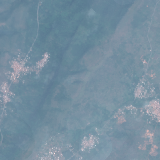

In [42]:
#20  12
indx = 5
loaded = np.load(images_divided[indx].data_real_path, allow_pickle=True)
display_np_geoTiff(loaded['array1'])
# display_geoTiff(gdal.Open(images_divided[indx].data_real_path))


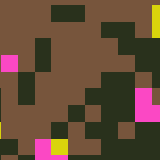

In [46]:
np_gh_img = np.asarray(iu.read_image(
    images_divided[indx].label_path.replace('.npz', '.png')))
display_legend(np_gh_img, new_color_encoding)

In [ ]:
display_legend(np.asarray(iu.read_image(
    'data/segmentation/original/mask/Final_RLCM_Ghana_2017.png')), new_color_encoding)

In [47]:
#numpy utils
def flip_np_image_left_right(np_image):
    # Flip the array from left to right
    return np.fliplr(np_image)


def rotate_np_image(np_image, angle):
    return np.rot90(np_image, k=int((360 - angle) / 90))

def resize_np_image(np_image, size):
    height, width = size
    no_channels = np_image.shape[2]
    output = np.zeros(
        (int(height), int(width), no_channels), str(np_image.dtype))
    for x in range(no_channels):
        channel = np.array(np_image[:, :, x], str(np_image.dtype))
        channel_image = Image.fromarray(channel)
        channel_image = channel_image.resize((width, height))
        channel = np.asarray(channel_image)
        output[..., x] = channel
    return output


In [262]:
np_gt = read_geoTiff_bands(gdal.Open(images_divided[indx].data_real_path))
# display_geoTiff(save_np_array_as_geoTiff)


In [61]:
# Augments images by rotation.
def aug_image(image, new_size=None):
    width, height = image.size
    if new_size == None:
        new_size = (width, height)
    images_augmented = []
    image = image.resize(new_size)
    new_im = image
    images_augmented.append(new_im)
    images_augmented.append(new_im.rotate(90))
    images_augmented.append(new_im.rotate(180))
    images_augmented.append(new_im.rotate(270))
    new_im = image.transpose(Image.FLIP_LEFT_RIGHT)
    images_augmented.append(new_im)
    images_augmented.append(new_im.rotate(90))
    images_augmented.append(new_im.rotate(180))
    images_augmented.append(new_im.rotate(270))
    return images_augmented


def aug_np_image(np_image, new_size=None):
    height, width , channels = np_image.shape[0], np_image.shape[1], np_image.shape[2]
    if new_size == None:
        new_size = (height, width)
    np_images_aug = []
    np_image = resize_np_image(np_image, new_size)
    new_np_im = np_image
    np_images_aug.append(new_np_im)
    np_images_aug.append(rotate_np_image(new_np_im, 90))
    np_images_aug.append(rotate_np_image(new_np_im, 180))
    np_images_aug.append(rotate_np_image(new_np_im, 270))
    new_np_im = flip_np_image_left_right(np_image)
    np_images_aug.append(new_np_im)
    np_images_aug.append(rotate_np_image(new_np_im, 90))
    np_images_aug.append(rotate_np_image(new_np_im, 180))
    np_images_aug.append(rotate_np_image(new_np_im, 270))
    return np_images_aug


In [57]:
def load_numpy_file(path):
    loaded = np.load(path, allow_pickle=True)
    return loaded['array1']

def save_numpy_file(np_arr,path):
    np.savez(path, array1=np_arr)


In [53]:
divided_images_path = iu.get_all_files(real_divided_data_path)

In [55]:
images_divided = []
for path in divided_images_path:
    image = DataLabelPair(os.path.join(real_divided_data_path, path),
                          os.path.join(mask_divided_data_path, path.replace('.npz', '.png')))
    images_divided.append(image)

In [62]:
# images are augmented and saved on disk.
iu.create_dir_if_not_exists(final_data_path)
iu.create_dir_if_not_exists(real_final_data_path)
iu.create_dir_if_not_exists(mask_final_data_path)
for image in images_divided:
    real_image = load_numpy_file(image.data_real_path)
    mask_image = iu.read_image(image.label_path, 'L')
    real_aug_images = aug_np_image(real_image, (160, 160))
    mask_aug_images = aug_image(mask_image, (160, 160))
    for x in range(len(real_aug_images)):
        part_filename = str(uuid.uuid4())
        real_image_part = real_aug_images[x]
        mask_image_part = mask_aug_images[x]
        #
        save_numpy_file(real_image_part, os.path.join(
            real_final_data_path, part_filename + '.npz'))
        mask_image_part.save(os.path.join(
            mask_final_data_path, part_filename + '.png'))


In [18]:
# Categorical cross entropy
y_true = [[0, 1, 0], [0, 0, 1]]  # One-hot encoded labels
y_pred = [[0.1, 0.9, 0], [0.1, 0.1, 0.8]]  # Predicted probabilities
loss0 = tf.losses.categorical_crossentropy(y_true, y_pred)

# Sparse categorical cross entropy
y_true = [1, 2]  # Integer labels
y_pred = [[0.1, 0.9, 0], [0.1, 0.1, 0.8]]  # Predicted probabilities
loss1 = tf.losses.sparse_categorical_crossentropy(y_true, y_pred)
print('loss0 = ', loss0, 'loss1 = ', loss1)

loss0 =  tf.Tensor([0.10536055 0.22314353], shape=(2,), dtype=float32) loss1 =  tf.Tensor([0.10536067 0.22314355], shape=(2,), dtype=float32)


In [ ]:
import rasterio
import numpy as np


def preprocess_data(data):
    # Add your preprocessing function here
    return data


class DataGenerator:
    def __init__(self, filepath, mask_filepath, batch_size):
        self.filepath = filepath
        self.mask_filepath = mask_filepath
        self.batch_size = batch_size

    def __iter__(self):
        with rasterio.open(self.filepath) as src:
            data = src.read()
            data = preprocess_data(data)
            with rasterio.open(self.mask_filepath) as mask:
                mask_data = mask.read()
                for i in range(0, data.shape[0], self.batch_size):
                    data_batch = data[i:i + self.batch_size]
                    mask_batch = mask_data[i:i + self.batch_size]
                    yield (data_batch, mask_batch)


# Example usage
generator = DataGenerator(
    'path/to/file.tiff', 'path/to/mask.tiff', batch_size=32)
for data, mask in generator:
    print(data.shape)  # should output (batch_size, 6, height, width)
    print(mask.shape)  # should output (batch_size, 1, height, width)

In [ ]:
import numpy as np
import rasterio
from keras.utils import Sequence


class GeoTIFFDataGenerator(Sequence):
    def __init__(self, image_filenames, labels, batch_size=32, image_size=(256, 256)):
        self.image_filenames = image_filenames
        self.labels = labels
        self.batch_size = batch_size
        self.image_size = image_size

    def __len__(self):
        return int(np.ceil(len(self.image_filenames) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.image_filenames[idx *
                                       self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx *
                              self.batch_size:(idx + 1) * self.batch_size]

        return self.__data_generation(batch_x, batch_y)

    def __data_generation(self, batch_x, batch_y):
        X = np.empty((self.batch_size, *self.image_size, 6))
        y = np.empty((self.batch_size))

        for i, image_filename in enumerate(batch_x):
            with rasterio.open(image_filename) as src:
                X[i, ] = src.read(out_shape=self.image_size+(6,))
            y[i] = batch_y[i]

        return X, y


In [77]:
# import os
# import rasterio
# import numpy as np
from tensorflow.keras.utils import Sequence
import ntpath


def preprocess_data(data):
    # Add your preprocessing function here
    return data

class DataGenerator(Sequence):
    def __init__(self, image_dir, batch_size=32, shuffle=True, real_data_preprocessing_function=None, mask_data_preprocessing_function=None):
        self.image_dir = image_dir
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.size = (160, 160)
        self.real_data_preprocessing_function = real_data_preprocessing_function
        self.mask_data_preprocessing_function = mask_data_preprocessing_function
        self.image_list, self.mask_list = self.__load_filenames()

    def __len__(self):
        return len(self.image_list) // self.batch_size

    def __getitem__(self, index):
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        image_list_temp = [self.image_list[k] for k in indexes]
        mask_list_temp = [self.mask_list[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(image_list_temp, mask_list_temp)

        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_list))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __load_filenames(self):
        # image_list = []
        mask_list = []
        image_list = iu.get_all_files(
            os.path.join(self.image_dir, 'real'), '*.npz', True)
        for real_image_path in image_list:
            mask_path = os.path.join(self.image_dir, 'mask', ntpath.basename(
                real_image_path).replace('.npz', '.png'))
            if not os.path.isfile(mask_path):
               raise Exception("Cannot find mask for " + real_image_path)
            mask_list.append(mask_path)
        # mask_list = iu.get_all_files(
        #     os.path.join(self.image_dir, 'mask'), '*.png', True)
        # for x in range(len(image_list)):
        #     if ntpath.basename(image_list[x]).replace('.npz', '') != ntpath.basename(mask_list[x]).replace('.png', ''):
        #         raise Exception("Cannot find mask for " + image_list[x])
        print(
            f"Found {len(image_list)} image pair.")
        # for real_file in real_files_path:
        #     image
        # for file in os.listdir(self.image_dir):
        #     if file.endswith('.tiff'):
        #         if 'mask' in file:
        #             mask_list.append(file)
        #         else:
        #             image_list.append(file)
        return image_list, mask_list

    def __data_generation(self, image_list_temp, mask_list_temp):
        width, height = self.size
        X = np.empty((self.batch_size, height, width, 6))
        y = np.empty((self.batch_size, height, width))
        for i, (image_name, mask_name) in enumerate(zip(image_list_temp, mask_list_temp)):
            np_gt = load_numpy_file(image_name)
            mask_image = iu.read_image(mask_name)
            if np_gt.shape != (height, width):
                np_gt = resize_np_image(np_gt, self.size)
            if mask_image.size != self.size:
                mask_image =mask_image.resize(self.size)
            np_mask_image = np.asarray(mask_image, dtype='uint8')
            if self.real_data_preprocessing_function != None:
                np_gt = self.real_data_preprocessing_function(np_gt)
            if self.mask_data_preprocessing_function != None:
                np_mask_image = self.mask_data_preprocessing_function(np_mask_image)
            X[i, ] = np_gt
            y[i, ] = np_mask_image
        # Read images and masks into memory
        # for i, (image_name, mask_name) in enumerate(zip(image_list_temp, mask_list_temp)):
        #     with rasterio.open(self.image_dir + image_name) as src:
        #         X[i, ] = src.read()

        #     with rasterio.open(self.image_dir + mask_name) as src:
        #         y[i, ] = src.read()

        return X, y


In [78]:
dg = DataGenerator(final_data_path, 32, False)

Found 85568 image pair.


In [ ]:
image_filenames = ['image1.tiff', 'image2.tiff', ...]
labels = [0, 1, ...]
batch_size = 32

# create the DataGenerator
data_generator = GeoTIFFDataGenerator(
    image_filenames, labels, batch_size=batch_size)

# fit the model
model.fit(data_generator, epochs=10)


Prepare Train, val and test folder

In [10]:
# Splits dataset into training, validation and test sets.
def train_val_test_split(val_per, test_per, input_data, labels=None):
    if labels is not None and len(input_data) != len(labels):
        raise Exception("input data and label length mismatch")
    data_len = len(input_data)
    val_len = int(data_len * (val_per / 100))
    test_len = int(data_len * (test_per / 100))
    x_val = input_data[0: val_len]
    x_test = input_data[val_len: val_len + test_len]
    x_train = input_data[val_len + test_len: data_len]
    if labels is not None:
        y_val = labels[0: val_len]
        y_test = labels[val_len: val_len + test_len]
        y_train = labels[val_len + test_len: data_len]
        return (x_train, y_train), (x_val, y_val), (x_test, y_test)
    else:
        return x_train, x_val, x_test

In [16]:
final_images_path = iu.get_all_files(real_final_data_path, '*.npz')

In [18]:
images_final = []
for path in final_images_path:
    image = DataLabelPair(os.path.join(real_final_data_path, path),
                          os.path.join(mask_final_data_path, path.replace('.npz', '.png')))
    images_final.append(image)


In [19]:
train_images, val_images, test_images = train_val_test_split(
    15, 0, images_final)
print('Train length:', len(train_images))
print('Val length:', len(val_images))
print('Test length', len(test_images))


Train length: 0
Val length: 151
Test length 0


In [13]:
#create directories for all training data.
training_path = os.path.join(segmentation_path, 'training')
iu.create_dir_if_not_exists(training_path)
#train
train_path = os.path.join(training_path, 'train')
iu.create_dir_if_not_exists(train_path)
train_real_path = os.path.join(train_path, 'real')
iu.create_dir_if_not_exists(train_real_path)
train_mask_path = os.path.join(train_path, 'mask')
iu.create_dir_if_not_exists(train_mask_path)
#val
val_path = os.path.join(training_path, 'val')
iu.create_dir_if_not_exists(val_path)
val_real_path = os.path.join(val_path, 'real')
iu.create_dir_if_not_exists(val_real_path)
val_mask_path = os.path.join(val_path, 'mask')
iu.create_dir_if_not_exists(val_mask_path)
#test
test_path = os.path.join(training_path, 'test')
iu.create_dir_if_not_exists(test_path)
test_real_path = os.path.join(test_path, 'real')
iu.create_dir_if_not_exists(test_real_path)
test_mask_path = os.path.join(test_path, 'mask')
iu.create_dir_if_not_exists(test_mask_path)


In [14]:
# copy training images to training folder
for image in train_images:
    shutil.move(image.data_real_path, os.path.join(
        train_real_path, os.path.basename(image.data_real_path)))
    shutil.move(image.label_path, os.path.join(
        train_mask_path, os.path.basename(image.label_path)))

In [20]:
# copy training images to training folder
for image in val_images:
    shutil.move(image.data_real_path, os.path.join(
        val_real_path, os.path.basename(image.data_real_path)))
    shutil.move(image.label_path, os.path.join(
        val_mask_path, os.path.basename(image.label_path)))

In [ ]:
# copy training images to training folder
for image in test_images:
    shutil.move(image.data_real_path, os.path.join(
        test_real_path, os.path.basename(image.data_real_path)))
    shutil.move(image.label_path, os.path.join(
        test_mask_path, os.path.basename(image.label_path)))